# Optimal charging station location on a cycleway


Consider a long linear cycle path  as Vento (VENezia-TOrino), or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. These places, called **Points of Interest (POI)**  are not on the main trajectory of the cyclepath, but the bikers must deviate to reach them.

We assume that the bikers enter the cyclepath where it begins and finish the trip ath the end of the cyclepath. When they enter the battery is fully charged. Moreover, the bikers will make all possible deviations in order to visit all the POIs.







## Formulation

To support the formulation we make use of a graph with $2n+2$ nodes.
Nodes $s$ and $t$ represent the extremes of the cyclepath.

Nodes

*   $L = \{1,\ldots,n\}$:  locations along the cyclepath from which bikers deviate


*   $H = \{1',\ldots, n'\}$:  POIs that may host a charging station.

*   $\{s,t\}$: extremes of the cyclepath.

Arcs

*  $\{(i,i+1), (i+1, i) 1,\ldots,n \}$: arcs of the cyclepath in the two directions

*  $\{(i,i'), (i',i), i\in L, i'\in H\}$: arcs representing the deviations from the cyclepath

### Example of the graph
![picture](https://drive.google.com/file/d/1A4dSP-4K1E3jwaab4A8JT21TKD7FINaK/view?usp=drive_link)

### Parameters

*   $d_{i,i+1}, d_{i+1,i}, i=1,\ldots,n-1$: energy consumption between consecutive nodes,
*   $d_{i,i'}, d_{i',i}, i \in L, i'\in H$: energy consumption for the deviations
*   $c_i'$: cost of installing a charging station in site $i' \in H$
*   $\Delta$: maximum energy consumption between consecutive charging stations

We assume that $d_{s,1} d_{1,s} = d_{n,t} = d_{t,n} = 0$.
Note that the energy consumption on each arc can be different in the two directions, depending on the orography.








## Problem 1

Consider a biker that traverses the cyclepath from $s$ to $t$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.



## Problem 2

Consider a biker that traverses the cyclepath from $t$ to $s$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.

### Comments
Do you obtain the same solution? Why?

### Recommendation
The problems can be solved by a simple formulation. The solution of complex problems as the TSP is not necessary.
Do not use external libraries apart from those presented in class.



In [3]:
#import libraries

#pip install mip
#pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx

## Solution Problem 1

In [4]:
#data PROBLEM 1
n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n  # destination
c = [20, 32, 11, 37, 7, 14, 22, 5, 35, 17, 23, 3, 26, 24] # consumption (in Wh) between two consecutive location along the main course
c_d = [1.1, 0.7, 0.4, 0.9, 2.1, 1.8, 0.5, 0.4, 1.6, 2.5, 1.4, 0.8, 2.0, 1.3, 0.1] # consumption (in Wh) of the deviation
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756] #cost (in €) of installation of a charging point related to the node

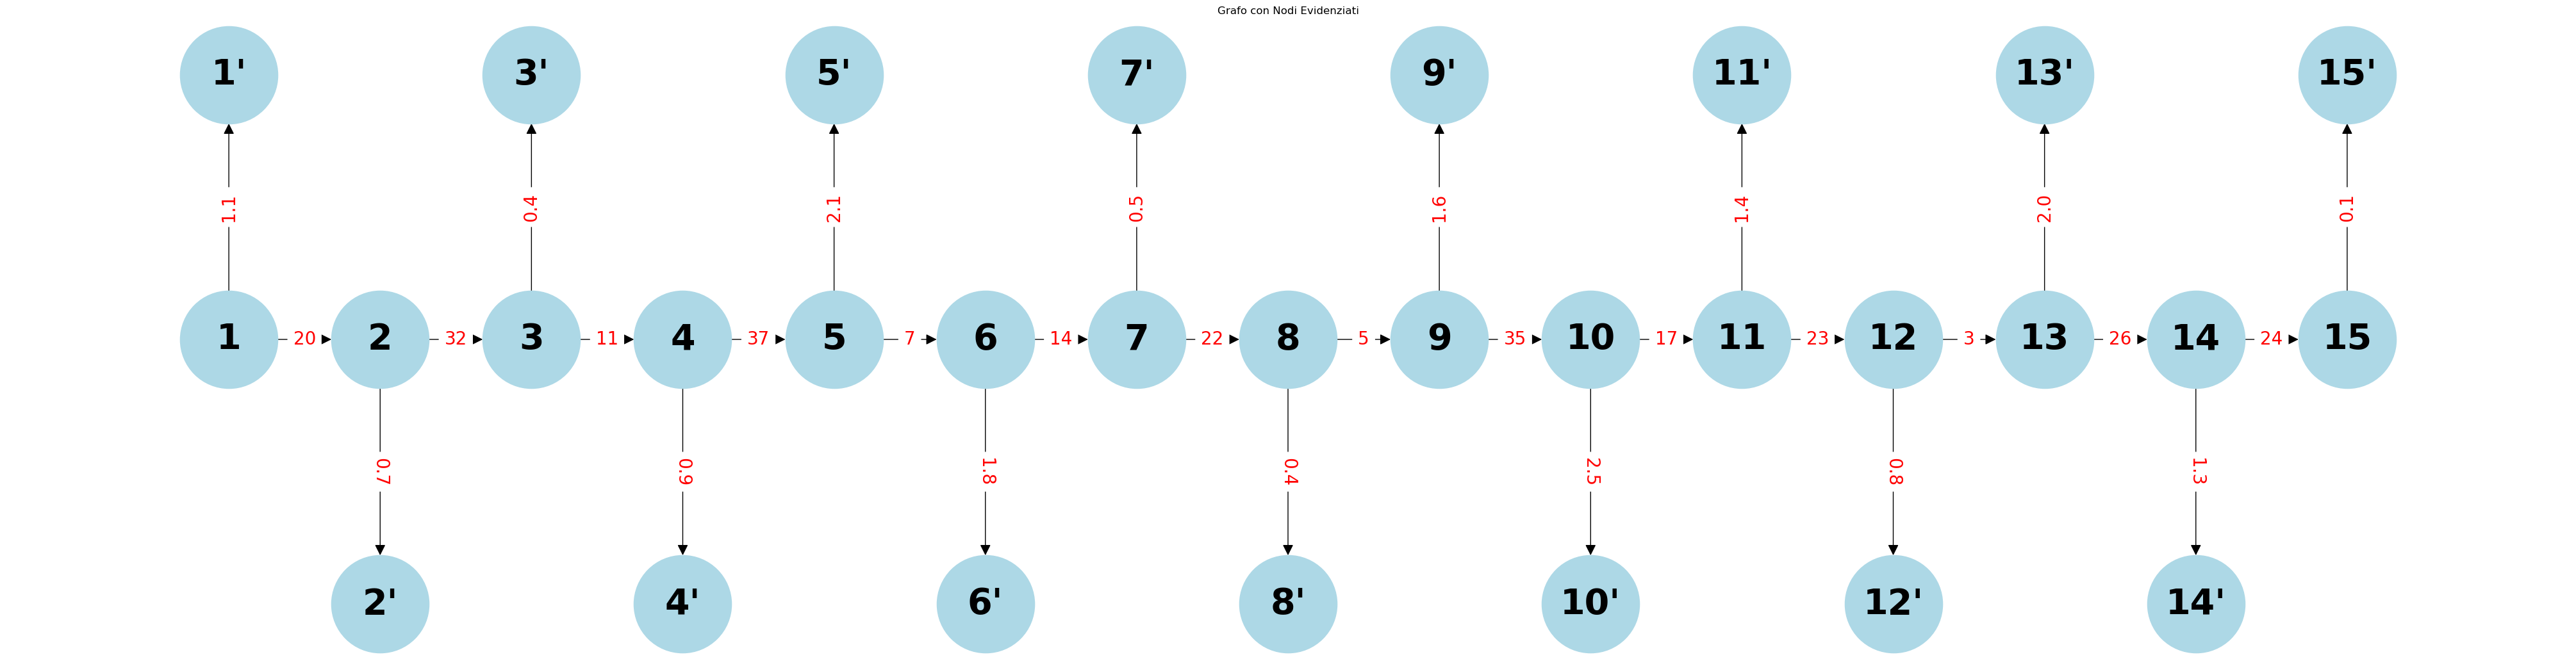

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Creazione del grafo
G = nx.DiGraph()

# Aggiunta degli archi principali com i rispettivi pesi
main_edges = [ (i, i + 1, c[i - 1]) for i in range(1,15)]
G.add_weighted_edges_from(main_edges)

# Aggiunta degli archi secondari con i rispettivi pesi
secondary_edges = [(i, f'{i}\'', c_d[i - 1]) for i in range(1,16)]
G.add_weighted_edges_from(secondary_edges)

# creazione dizionario coordinate nodi
pos = {}

for i in range(1,16):
    pos[i] = (i, 0)

for i, node in enumerate(["1'", "2'", "3'", "4'", "5'", "6'", "7'", "8'", "9'", "10'", "11'", "12'", "13'", "14'", "15'"]):
    pos[node] = (i + 1, 1 if i % 2 == 0 else -1) # Posiziona i nodi con l'apostrofo alternati sopra e sotto la linea principale

# Disegno del grafo
plt.figure(figsize=(40, 10))
nx.draw(G, pos = pos, with_labels=True, node_size=12000, node_color='lightblue', font_size=40, font_weight='bold', arrowsize=25)

# Disegno dei pesi degli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos = pos , edge_labels=edge_labels, font_color='red', font_size=20)

plt.title('Grafo con Nodi Evidenziati')
plt.show()

In [8]:
import mip
import numpy as np

# Create model
m = mip.Model()

# define the variable
x = [m.add_var(var_type=mip.BINARY) for i in range(n1)]  # charging stations
y = [m.add_var(var_type=mip.CONTINUOUS, lb=0) for i in range(n1)] # y[i] is zero if x[i] = 0, otherwise it's equal to the energy consumed until station i
#  define the contraints
M = sum(c_d + c_d + c)
m.add_constr(  2*c_d[0] + c[0] + c_d[i] <= delta + M*x[0]  )
m.add_constr(  y[0] == x[0]*c_d[0]  )
for i in range(1, n1-1):
    m.add_constr(  y[i-1] + c_d[i-1] + c[i-1] + 2*c_d[i] + c[i] + c_d[i+1] <= delta + M*x[i] )
    m.add_constr(  y[i] <= M*(1-x[i])  )
    m.add_constr(  y[i-1] + c_d[i-1] + c[i-1] + c_d[i] <= y[i] + M*x[i]  )
    m.add_constr(  y[i-1] + c_d[i-1] + c[i-1] + c_d[i] >= y[i] - M*x[i]  )
m.add_constr(  y[n1-2] + c_d[n1-2] + c[n1-2] + 2*c_d[n1-1] <= delta + M*x[n1-1]  )

# minimize cost of installation
m.objective = mip.minimize(np.dot(inst_cost, x))

# optimitation of the model
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [9]:
stazioni_instal = [(i+1) for i, _ in enumerate(x) if x[i].x != 0 ]
print("PROBLEMA 1 \nValore funzione obbiettivo: %d \nStazioni installate: %s" %(m.objective_value, stazioni_instal))

PROBLEMA 1 
Valore funzione obbiettivo: 12348 
Stazioni installate: [2, 4, 5, 7, 8, 10, 12, 14]


## Solution Problem 2

In [10]:
#data PROBLEM 2

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n  # destination
c2 = [12, 24, 7, 8, 35, 21, 19, 9, 31, 15, 21, 6, 23, 29] # consumption (in Wh) between two consecutive location along the main course
c_d2 = [1.7, 2.1, 1.1, 0.3, 0.4, 2.3, 0.2, 0.9, 2.1, 4.3, 5.2, 0.1, 2.8, 0.9, 0.1] # consumption (in Wh) of the deviation


#to compute the installation cost you have to bring the vector from the PROBLEM 1 and reverse it
inst_cost_rev = inst_cost[::-1]
#TO DO


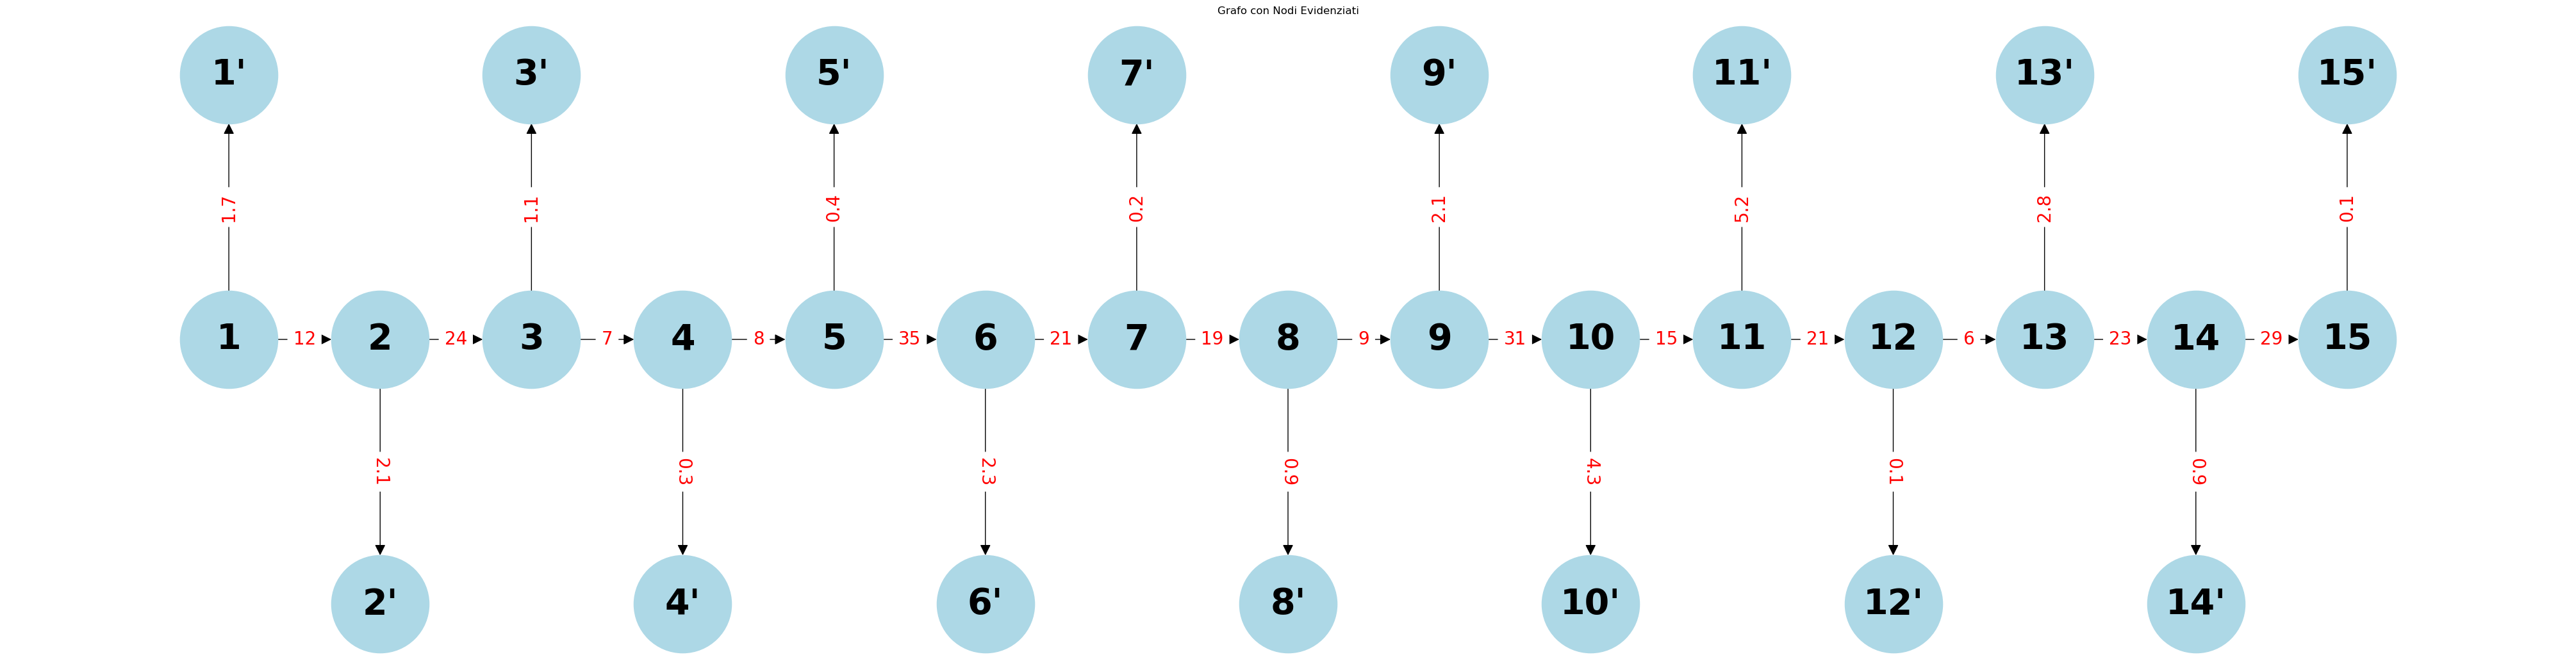

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Creazione del grafo
G = nx.DiGraph()

# Aggiunta degli archi principali com i rispettivi pesi
main_edges = [ (i, i + 1, c2[i - 1]) for i in range(1,15)]
G.add_weighted_edges_from(main_edges)

# Aggiunta degli archi secondari con i rispettivi pesi
secondary_edges = [(i, f'{i}\'', c_d2[i - 1]) for i in range(1,16)]
G.add_weighted_edges_from(secondary_edges)

# creazione dizionario coordinate nodi
pos = {}

for i in range(1,16):
    pos[i] = (i, 0)

for i, node in enumerate(["1'", "2'", "3'", "4'", "5'", "6'", "7'", "8'", "9'", "10'", "11'", "12'", "13'", "14'", "15'"]):
    pos[node] = (i + 1, 1 if i % 2 == 0 else -1) # Posiziona i nodi con l'apostrofo alternati sopra e sotto la linea principale

# Disegno del grafo
plt.figure(figsize=(40, 10))
nx.draw(G, pos = pos, with_labels=True, node_size=12000, node_color='lightblue', font_size=40, font_weight='bold', arrowsize=25)

# Disegno dei pesi degli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos = pos , edge_labels=edge_labels, font_color='red', font_size=20)

plt.title('Grafo con Nodi Evidenziati')
plt.show()

In [12]:
import mip
import numpy as np

# Create model
m = mip.Model()

# define the variable
x = [m.add_var(var_type=mip.BINARY) for i in range(n1)]  # charging stations
y = [m.add_var(var_type=mip.CONTINUOUS, lb=0) for i in range(n1)] # y[i] is zero if x[i] = 0, otherwise it's equal to the energy consumed until station i
#  define the contraints
M = sum(c_d2 + c_d2 + c2)
m.add_constr(  2*c_d2[0] + c2[0] + c_d2[i] <= delta + M*x[0]  )
m.add_constr(  y[0] == x[0]*c_d2[0]  )
for i in range(1, n1-1):
    m.add_constr(  y[i-1] + c_d2[i-1] + c2[i-1] + 2*c_d2[i] + c2[i] + c_d2[i+1] <= delta + M*x[i] )
    m.add_constr(  y[i] <= M*(1-x[i])  )
    m.add_constr(  y[i-1] + c_d2[i-1] + c2[i-1] + c_d2[i] <= y[i] + M*x[i]  )
    m.add_constr(  y[i-1] + c_d2[i-1] + c2[i-1] + c_d2[i] >= y[i] - M*x[i]  )
m.add_constr(  y[n1-2] + c_d2[n1-2] + c2[n1-2] + 2*c_d2[n1-1] <= delta + M*x[n1-1]  )

# minimize cost of installation
m.objective = mip.minimize(np.dot(inst_cost_rev, x))

# optimitation of the model
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [13]:
stazioni_instal = [(i+1) for i, _ in enumerate(x) if x[i].x != 0 ]
print("PROBLEMA 2 \nValore funzione obbiettivo: %d \nStazioni installate: %s" %(m.objective_value, stazioni_instal))

PROBLEMA 2 
Valore funzione obbiettivo: 12924 
Stazioni installate: [3, 4, 6, 8, 10, 11, 12, 14]



Do you obtain the same solution? Why?  
The two problems are characterized by different optimal solutions (on the way out, a different set of stations is installed compared to the return journey); specifically, for the return path, the optimal installation costs are higher. This characterization arises from the fact that the two problems are formulated differently, specifically they have:

- identical objective functions;
- identical sets and types of variables;
- the same constraint coefficients (they share the same matrix of coefficients);
- different right-hand side vectors.

The fact that the right-hand side vector in problem 2 differs from that in problem 1 means that each constraint in problem 1 is shifted by a certain amount in the direction of the gradient. Consequently, the feasible region of problem 2 will be deformed compared to that of problem 1, thus including new feasible solutions and/or eliminating old ones. In problem 2, the optimal solution of problem 1 is therefore discarded as it is no longer feasible, and a worse optimal solution than the previous one is chosen, as the new feasible region did not manage to include new solutions that are better than the optimal one in problem 1. It is plausible that the change in consumption between the stages, that is, the matrix of coefficients, from one problem to the other, is due to the fact that sections of the route that were uphill (downhill) on the way out now have to be traveled downhill (uphill), leading to a change in battery energy consumption.

